# Convert and Optimize YOLOv8 with OpenVINO™

The YOLOv8 algorithm developed by Ultralytics is a cutting-edge, state-of-the-art (SOTA) model that is designed to be fast, accurate, and easy to use, making it an excellent choice for a wide range of object detection, image segmentation, and image classification tasks.

YOLO stands for "You Only Look Once", it is a popular family of real-time object detection algorithms. The original YOLO object detector was first released in 2016. Since then, different versions and variants of YOLO have been proposed, each providing a significant increase in performance and efficiency. YOLOv8 builds upon the success of previous YOLO versions and introduces new features to boost performance and flexibility further. More details about its realization can be found in the original model [repository](https://github.com/ultralytics/ultralytics).

Real-time object detection is often used as key component in computer vision systems. Applications that use real-time object detection models include video analytics, robotics, autonomous vehicles, multi-object tracking and object counting, medical image analysis, and many others.

This tutorial demonstrates step-by-step instructions on how to convert and optimize PyTorch YOLOv8 with OpenVINO. We consider the steps required for an object detection scenario.

Generally, PyTorch models represent an instance of the [torch.nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) class, initialized by a state dictionary with model weights. We will use the YOLOv8 medium model (also known as `yolov8m`) pre-trained on the COCO dataset, which is available in this [repo](https://github.com/ultralytics/ultralytics). Similar steps are also applicable to other YOLOv8 models.
Typical steps to obtain a pre-trained model:
1. Create an instance of a model class
2. Load checkpoint state dict, which contains pre-trained model weights
3. Turn the model to evaluation for switching some operations to inference mode

In this case, the model creators provide an API that enables converting the YOLOv8 model to ONNX and then to OpenVINO IR, so we don't need to do these steps manually.

## Define an image for sanity testing

Let's use the following image to ensure YOLOv8 is able to detect people in the queue.

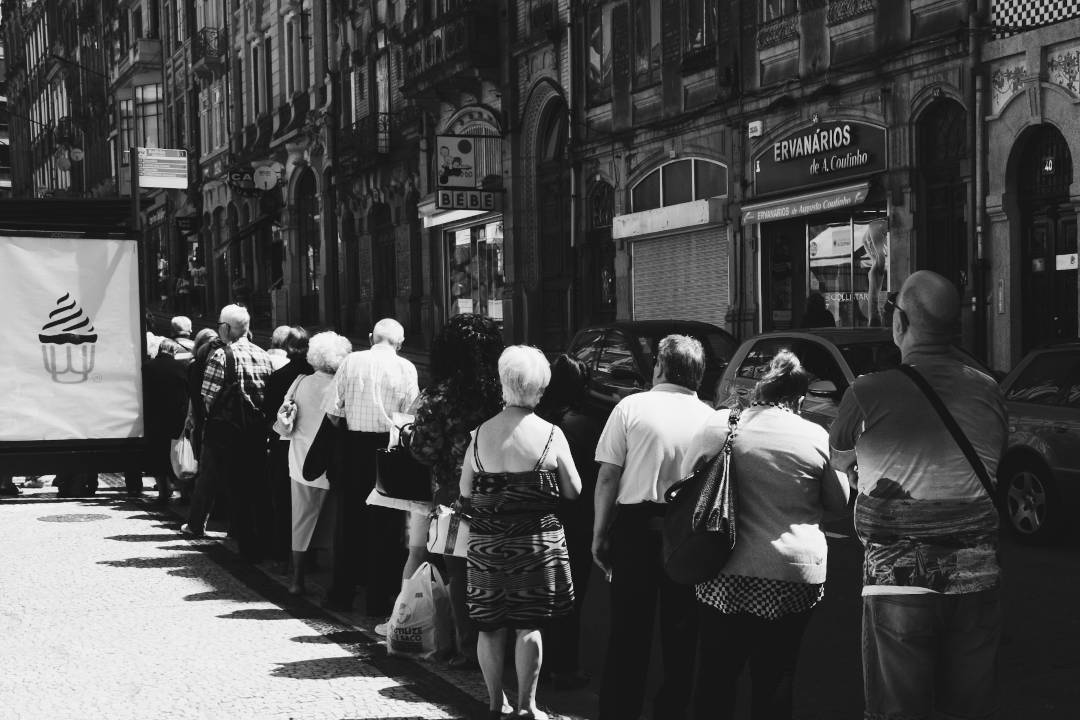

In [1]:
from PIL import Image

IMAGE_PATH = "../data/pexels-catia-matos-1604200.jpg"

Image.open(IMAGE_PATH)

## Instantiate the model

Several models are available in the original repository, targeted for different tasks. We need to specify a path to the model checkpoint to load the model. It can be some local path or name available on the models' hub (in this case model checkpoint will be downloaded automatically).

Making prediction, the model accepts a path to input image and returns a list with the Result class object. Also, it includes utilities for processing results, e.g., `plot()` method for drawing.

In [2]:
from ultralytics import YOLO

# the name of the model we want to use
DET_MODEL_NAME = "yolov8m"

# create a model
det_model = YOLO(f"../model/{DET_MODEL_NAME}.pt")

# class 0 means person
res = det_model(IMAGE_PATH, classes=[0])[0]

100%|██████████| 49.7M/49.7M [00:09<00:00, 5.37MB/s]

image 1/1 /home/adrian/repos/openvino_notebooks/recipes/intelligent_queue_management/docs/../data/pexels-catia-matos-1604200.jpg: 448x640 16 persons, 44.4ms
Speed: 1.1ms preprocess, 44.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Let's show the result to be sure everything works correctly.

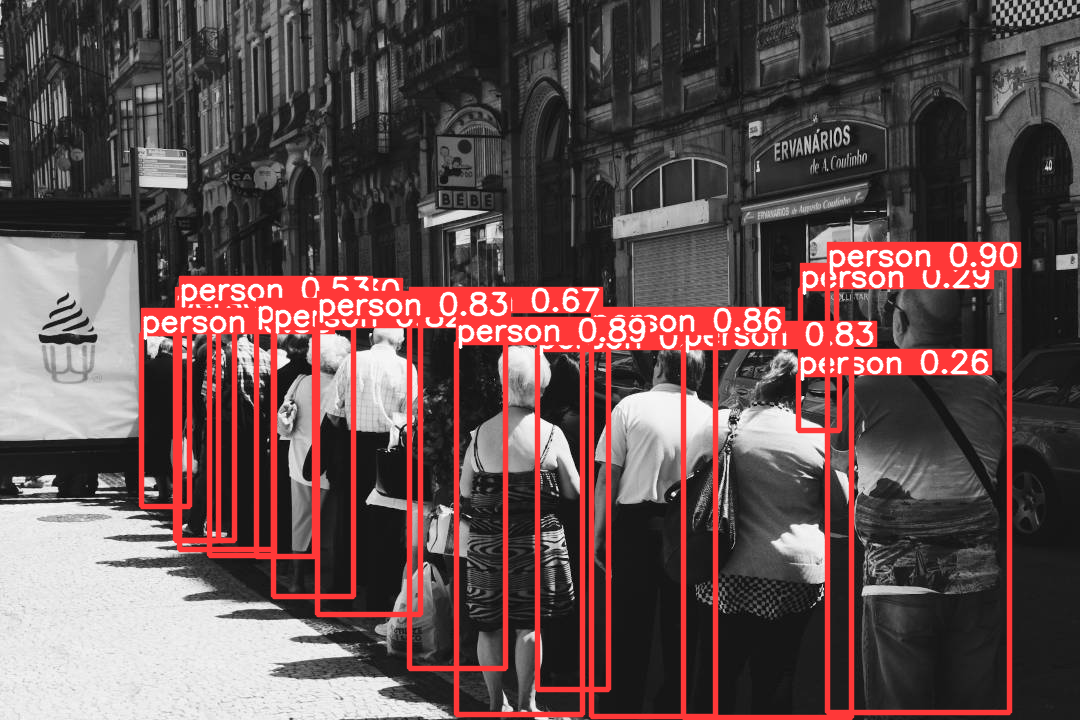

In [3]:
Image.fromarray(res.plot(line_width=3)[:, :, ::-1])

## Convert model to OpenVINO IR

YOLOv8 provides API for convenient model exporting to different formats, including OpenVINO IR. `model.export` is responsible for model conversion. We need to specify the format, and additionally, we could preserve dynamic shapes in the model. It would limit us to use CPU only, so we're not doing this. Also, we specify we want to use half-precision (FP16) to get better performance.

In [4]:
from pathlib import Path

ov_model_path = Path(f"../model/{DET_MODEL_NAME}_openvino_model/{DET_MODEL_NAME}.xml")

if not ov_model_path.exists():
    # export model to OpenVINO format
    out_dir = det_model.export(format="openvino", dynamic=False, half=True)

Ultralytics YOLOv8.0.117 🚀 Python-3.10.6 torch-2.0.1+cu117 CPU

PyTorch: starting from ../model/yolov8m.pt with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 84, 8400) (49.7 MB)

ONNX: starting export with onnx 1.14.0 opset 17...
ONNX: export success ✅ 0.9s, saved as ../model/yolov8m.onnx (99.0 MB)


============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================




OpenVINO: starting export with openvino 2023.0.0-10926-b4452d56304-releases/2023/0...
OpenVINO: export success ✅ 0.8s, saved as ../model/yolov8m_openvino_model/ (49.8 MB)

Export complete (2.1s)
Results saved to /home/adrian/repos/openvino_notebooks/recipes/intelligent_queue_management/model
Predict:         yolo predict task=detect model=../model/yolov8m_openvino_model imgsz=640 
Validate:        yolo val task=detect model=../model/yolov8m_openvino_model imgsz=640 data=coco.yaml 
Visualize:       https://netron.app


The model is converted now, but one more option exists to make the inference faster. We can quantize our network.

## Quantize the model

Quantization is a well-known technique to achieve better performance by decreasing the precision of the model (FP16 -> UINT8). To accomplish that, we will use Neural Network Compression Framework (NNCF), part of the OpenVINO Toolkit. Quantization requires a representative dataset to compute statistics for the given model.

### Prepare the data

YOLOv8 is pre-trained on the COCO dataset, so we need to download that dataset to evaluate the model's accuracy. According to the instructions provided in the YOLOv8 repo, we also need to download annotations in the format used by the author of the model for use with the original model evaluation function.

>**Note**: In the first time, dataset downloading could take some minutes. Downloading speed depends on your internet connection.

In [5]:
from zipfile import ZipFile
import sys

sys.path.append("..")
import utils

DATA_URL = "http://images.cocodataset.org/zips/val2017.zip"
LABELS_URL = "https://github.com/ultralytics/yolov5/releases/download/v1.0/coco2017labels-segments.zip"
CFG_URL = "https://raw.githubusercontent.com/ultralytics/ultralytics/ed25db94268fe0e65030f0ddc55e6180e39ffe81/ultralytics/cfg/datasets/coco.yaml"

data_out_dir = Path('../data')

utils.download_file(DATA_URL, directory=data_out_dir, show_progress=True)
utils.download_file(LABELS_URL, directory=data_out_dir, show_progress=True)
utils.download_file(CFG_URL, directory=data_out_dir, show_progress=True)

if not (data_out_dir / "coco/labels").exists():
    with ZipFile(data_out_dir / 'coco2017labels-segments.zip' , "r") as zip_ref:
        zip_ref.extractall(data_out_dir)
    with ZipFile(data_out_dir / 'val2017.zip' , "r") as zip_ref:
        zip_ref.extractall(data_out_dir / 'coco/images')

'../data/val2017.zip' already exists.
'../data/coco2017labels-segments.zip' already exists.


../data/coco.yaml: 2.47kB [00:00, 3.63MB/s]                   


The next step is creating a data loader, which provides data for statistics computations.

In [6]:
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets
from ultralytics.yolo.data import augment

# create the COCO validation dataset
coco_dataset = datasets.CocoDetection(data_out_dir / "coco/images/val2017",
                                      annFile=data_out_dir / "coco/annotations/instances_val2017.json",
                                      transform=augment.Compose([lambda x: np.array(x), augment.ClassifyLetterBox(), augment.ToTensor()]))

# get the loader with batch size 1
det_data_loader = DataLoader(coco_dataset, batch_size=1, shuffle=True)

loading annotations into memory...
Done (t=0.25s)
creating index...
index created!


### Load the OpenVINO model for quantization

We load the model we want to quantize.

In [7]:
from openvino import runtime as ov

core = ov.Core()
ov_model = core.read_model(ov_model_path)

### Optimize model using NNCF Post-training Quantization API

[NNCF](https://github.com/openvinotoolkit/nncf) provides a suite of advanced algorithms for Neural Networks inference optimization in OpenVINO with minimal accuracy drop.
We will use 8-bit quantization in post-training mode (without the fine-tuning pipeline) to optimize YOLOv8.

The optimization process consist of the following steps:

1. Create a Dataset for quantization.
2. Run `nncf.quantize` for getting an optimized model.
3. Serialize OpenVINO IR model, using the `openvino.runtime.serialize` function.

In [8]:
import nncf
from typing import Dict


def transform_fn(data_item: Dict):
    """
    Quantization transform function. Extracts and preprocess input data from dataloader item for quantization.
    Parameters:
       data_item: Dict with data item produced by DataLoader during iteration
    Returns:
        input_tensor: Input data for quantization
    """
    return data_item[0]


quantization_dataset = nncf.Dataset(det_data_loader, transform_fn)

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, onnx, openvino


The `nncf.quantize` function provides an interface for model quantization. It requires an instance of the OpenVINO Model and quantization dataset. 
Optionally, some additional parameters for the configuration quantization process (number of samples for quantization, preset, ignored scope, etc.) can be provided. YOLOv8 model contains non-ReLU activation functions, which require asymmetric quantization of activations. We will use a `mixed` quantization preset to achieve a better result. It provides symmetric quantization of weights and asymmetric quantization of activations. For more accurate results, we should keep the operation in the postprocessing subgraph in floating point precision, using the `ignored_scope` parameter.

>**Note**: Model post-training quantization is a time-consuming process. Be patient. It can take several minutes, depending on your hardware.

In [9]:
ignored_scope = nncf.IgnoredScope(
    types=["Multiply", "Subtract", "Sigmoid"],  # ignore operations
    names=[
        "/model.22/dfl/conv/Conv",           # in the post-processing subgraph
        "/model.22/Add",
        "/model.22/Add_1"
    ]
)

int8_model_path = Path(f'../model/{DET_MODEL_NAME}_openvino_int8_model/{DET_MODEL_NAME}.xml')

if not int8_model_path.exists():
    # quantize
    quantized_model = nncf.quantize(ov_model, quantization_dataset, preset=nncf.QuantizationPreset.MIXED, ignored_scope=ignored_scope)
    # save to disk
    ov.serialize(quantized_model, str(int8_model_path))

INFO:nncf:3 ignored nodes was found by name in the NNCFGraph
INFO:nncf:6 ignored nodes was found by types in the NNCFGraph
INFO:nncf:Not adding activation input quantizer for operation: 201 /model.22/Sigmoid
INFO:nncf:Not adding activation input quantizer for operation: 230 /model.22/dfl/conv/Conv
INFO:nncf:Not adding activation input quantizer for operation: 257 /model.22/Sub
INFO:nncf:Not adding activation input quantizer for operation: 258 /model.22/Add_1
INFO:nncf:Not adding activation input quantizer for operation: 274 /model.22/Div_1
INFO:nncf:Not adding activation input quantizer for operation: 268 /model.22/Sub_1
INFO:nncf:Not adding activation input quantizer for operation: 283 /model.22/Mul_2


Biases correction: 100%|██████████| 83/83 [00:08<00:00,  9.91it/s]


And we're done! The model has been exported to `model/yolov8_openvino_int8_model` directory. Now it's time to use it in production!

## Check the performance

The following steps are optional. They show the performance difference between FP32 and INT8 models. The default device is the CPU, but it can be changed to GPU as well.

In [10]:
device = "CPU"  # "GPU"

We will use the `benchmark_app` utility to test the performance, asking for the latency mode. More info about available parameters [here](https://docs.openvino.ai/latest/openvino_inference_engine_samples_benchmark_app_README.html).

In [11]:
# Inference FP32 model (OpenVINO IR)
!benchmark_app -m $ov_model_path -d $device -hint latency -t 30

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2023.0.0-10926-b4452d56304-releases/2023/0
[ INFO ] 
[ INFO ] Device info:
[ INFO ] CPU
[ INFO ] Build ................................. 2023.0.0-10926-b4452d56304-releases/2023/0
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 20.91 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     images (node: images) : f32 / [...] / [1,3,640,640]
[ INFO ] Model outputs:
[ INFO ]     output0 (node: output0) : f32 / [...] / [1,84,8400]
[Step 5/11] Resizing model to match image sizes and given batch
[ INFO ] Model batch size: 1
[Step 6/11] Configuring input of the model
[ INFO ] Model inputs:
[ INFO ]     images (node: images) : u8 / [N,C,H,W] / [1,3,640,640]
[ INFO ] Model outputs:
[ INFO

In [12]:
# Inference INT8 model (OpenVINO IR)
!benchmark_app -m $int8_model_path -d $device -hint latency -t 30

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2023.0.0-10926-b4452d56304-releases/2023/0
[ INFO ] 
[ INFO ] Device info:
[ INFO ] CPU
[ INFO ] Build ................................. 2023.0.0-10926-b4452d56304-releases/2023/0
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 36.13 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     images (node: images) : f32 / [...] / [1,3,640,640]
[ INFO ] Model outputs:
[ INFO ]     output0 (node: output0) : f32 / [...] / [1,84,8400]
[Step 5/11] Resizing model to match image sizes and given batch
[ INFO ] Model batch size: 1
[Step 6/11] Configuring input of the model
[ INFO ] Model inputs:
[ INFO ]     images (node: images) : u8 / [N,C,H,W] / [1,3,640,640]
[ INFO ] Model outputs:
[ INFO